In [27]:
import torchvision

from torchvision.transforms import v2
from torchvision import tv_tensors

from sklearn import model_selection
from sklearn import metrics
#from torchvision import datapoints

import torchaudio

from models import RNN

import torch
from torch import nn
import cv2
import numpy as np

import scipy

import glob
import os

import time

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# Проверка экстрактора аудио

In [52]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
path_to_audio = r'C:\Users\admin\python_programming\DATA\AVABOS\2g7X7-D6HYY(+)_._0.066-10.066_._AGGR.wav'
name = os.path.split(path_to_audio)[-1][:-4]
extractor = bundle.get_model().to('cuda')
rnn = RNN(
    rnn_type=nn.LSTM,
    rnn_layers_num=1,
    input_dim=768,
    hidden_dim=512,
    class_num=2
).to('cuda')

opt = torch.optim.Adam(rnn.parameters())
criterion = nn.CrossEntropyLoss()
batch_size = 64
rnn.train()

times = []
for i in tqdm(range(0, 2200, batch_size)):
    t0 = time.time()
    features_list = []
    for j in range(batch_size):
        waveform, sample_rate = torchaudio.load(path_to_audio)
        waveform = waveform[0].to('cuda')
        if sample_rate != bundle.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)
        with torch.inference_mode():
            features, _ = extractor.extract_features(waveform.unsqueeze(0))
        features_list.append(features[-1])

    features = torch.cat(features_list, dim=0)
            #features = features[-1].cpu().numpy()
            #np.save(name+'.npy', features)

    true = torch.randint(0, 2, size=(batch_size,)).cuda()
    opt.zero_grad()
    pred = rnn(features)
    loss = criterion(pred, true)
    loss.backward()
    opt.step()

    times.append(time.time()-t0)

waveform.shape

print(np.mean(times), np.sum(times))
features.shape

100%|██████████| 35/35 [01:17<00:00,  2.22s/it]

2.21797821862357 77.62923765182495


torch.Size([64, 499, 768])

In [49]:
features.shape

torch.Size([1, 499, 768])

In [32]:
x = torch.randn(1, 3, 8)
torch.cat([x, x, x], 0).shape

torch.Size([3, 3, 8])

In [21]:
for idx, f in enumerate(features):
    print(idx, f.shape)


0 torch.Size([1, 499, 768])
1 torch.Size([1, 499, 768])
2 torch.Size([1, 499, 768])
3 torch.Size([1, 499, 768])
4 torch.Size([1, 499, 768])
5 torch.Size([1, 499, 768])
6 torch.Size([1, 499, 768])
7 torch.Size([1, 499, 768])
8 torch.Size([1, 499, 768])
9 torch.Size([1, 499, 768])
10 torch.Size([1, 499, 768])
11 torch.Size([1, 499, 768])


In [9]:
np.random.seed(1)
true = np.random.randint(0,2, size=50)
pred = np.random.randint(0,2, size=50)

print(metrics.recall_score(true, pred, average='binary'))
print(metrics.recall_score(true, pred, average='macro'))
print(metrics.recall_score(true, pred, average='micro'))
print(metrics.recall_score(true, pred, average=None))

0.6296296296296297
0.5756843800322061
0.58
[0.52173913 0.62962963]


In [13]:
class Permute(nn.Module):
    def forward(self, x):
        return x.permute(0, 4, 1, 2, 3)
    
model = torchvision.models.video.s3d().cuda()
model = nn.Sequential(*list(model.children())[:-2], nn.AdaptiveAvgPool3d(1), nn.Flatten()).cuda()#, Permute(), nn.AdaptiveAvgPool3d(1), nn.Flatten()).cuda()
size = (1, 3, 16, 112, 112)
model.eval()
out = model(torch.randn(*size).cuda())

times = []
for i in range(100):
    t0 = time.time()
    with torch.inference_mode():
        out = model(torch.randn(*size).cuda())
    times.append(time.time()-t0)

print(np.mean(times), out.shape)

0.022308921813964842 torch.Size([1, 1024])


In [ ]:
model

In [3]:
size = (1, 3, 16, 224, 224)
model = torchvision.models.video.s3d()
model = nn.Sequential(*list(model.children())[:-2], Permute()).cuda()#, Permute(), nn.AdaptiveAvgPool3d(1), nn.Flatten()).cuda()
out = model(torch.randn(*size).cuda())
out.shape

NameError: name 'Permute' is not defined

In [12]:
model

SwinTransformer3d(
  (patch_embed): PatchEmbed3d(
    (proj): Conv3d(3, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (features): Sequential(
    (0): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): ShiftedWindowAttention3d(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (proj): Linear(in_features=96, out_features=96, bias=True)
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (0): Linear(in_features=96, out_features=384, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=384, out_features=96, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
     

In [2]:
def read_video_frames_opencv(path_to_video):
    cap = cv2.VideoCapture(path_to_video)
    frames_list = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames_list.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    #return torch.tensor(np.array(frames_list).transpose(0, 3, 1, 2))
    #return tv_tensors.Video(np.array(frames_list).transpose(0, 3, 1, 2))
    return np.array(frames_list)#)#.transpose(0, 3, 1, 2)

In [7]:
model = None

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 9.78 GiB of which 39.44 MiB is free. Including non-PyTorch memory, this process has 9.32 GiB memory in use. Of the allocated memory 8.00 GiB is allocated by PyTorch, and 11.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [32]:
model = torchvision.models.video.mvit.mvit_v1_b().cuda()
model = nn.Sequential(*list(model.children())[:-2])#,nn.Flatten())
class MViT_extractor(torchvision.models.video.mvit.MViT):
    def forward(self, x):
        # Convert if necessary (B, C, H, W) -> (B, C, 1, H, W)
        x = _unsqueeze(x, 5, 2)[0]
        # patchify and reshape: (B, C, T, H, W) -> (B, embed_channels[0], T', H', W') -> (B, THW', embed_channels[0])
        x = self.conv_proj(x)
        x = x.flatten(2).transpose(1, 2)

        # add positional encoding
        x = self.pos_encoding(x)

        # pass patches through the encoder
        thw = (self.pos_encoding.temporal_size,) + self.pos_encoding.spatial_size
        for block in self.blocks:
            x, thw = block(x, thw)
        x = self.norm(x)

        # classifier "token" as used by standard language architectures
        return x[:, 0]


Sequential(
  (0): Conv3d(3, 96, kernel_size=(3, 7, 7), stride=(2, 4, 4), padding=(1, 3, 3))
  (1): PositionalEncoding()
  (2): ModuleList(
    (0): MultiscaleBlock(
      (norm1): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (norm2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
      (attn): MultiscaleAttention(
        (qkv): Linear(in_features=96, out_features=288, bias=True)
        (project): Sequential(
          (0): Linear(in_features=96, out_features=96, bias=True)
        )
        (pool_k): Pool(
          (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 8, 8), padding=(1, 1, 1), groups=96, bias=False)
          (norm_act): Sequential(
            (0): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          )
        )
        (pool_v): Pool(
          (pool): Conv3d(96, 96, kernel_size=(3, 3, 3), stride=(1, 8, 8), padding=(1, 1, 1), groups=96, bias=False)
          (norm_act): Sequential(
            (0): LayerNorm((96,), eps=1e-06, elem

In [2]:
model = torchvision.models.video.r3d_18()
model = nn.Sequential(*list(model.children())[:-1])#,nn.Flatten())
out = model(torch.randn(1, 3, 16, 112, 112))

out.shape
#model

torch.Size([1, 512, 2, 7, 7])

In [ ]:
torchvision.models.video.s3d()

In [ ]:
list(torchvision.models.video.s3d().children())[0]

In [71]:
cap = cv2.VideoCapture(path_to_video)
#cap.get(cv2.CAP_PROP_FRAME_COUNT)
while True:
    ret, frame = cap.read()
    if not ret:
        break

    print(frame.shape)
cap.release()

In [67]:
frames = read_video_frames_opencv(path_to_video)
frames

[]

In [3]:
paths_to_videos_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video\*.mp4')
paths_to_audios_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_audio\*.wav')
paths_to_audios_list[0], paths_to_videos_list[0]

('C:\\Users\\admin\\python_programming\\DATA\\AVABOS\\trash_to_train_on_audio\\-kpsb88q2ac(+)_._0.066-10.066_._NOAGGR.wav',
 'C:\\Users\\admin\\python_programming\\DATA\\AVABOS\\trash_to_train_on_video\\-kpsb88q2ac(+)_._0.066-10.066_._NOAGGR.mp4')

In [26]:
frames = read_video_frames_opencv(paths_to_videos_list[0])
frames.shape

(301, 270, 480, 3)

In [27]:
frames = torch.as_tensor(frames.transpose(0, 3, 1, 2))
frames.shape

torch.Size([301, 3, 270, 480])

In [28]:
tv_frames = tv_tensors.Video(frames)

In [29]:
resizer = v2.Resize(size=(224, 224), antialias=True)
tv_frames = resizer(tv_frames)
tv_frames.shape, frames.shape

(torch.Size([301, 3, 224, 224]), torch.Size([301, 3, 270, 480]))

In [ ]:
plt.imshow(tv_frames.numpy().transpose(0, 2, 3, 1)[0])

In [ ]:
frames = read_video_frames_opencv(paths_to_videos_list[0])
frames = torch.as_tensor(frames.transpose(0, 3, 1, 2))
print(frames.shape)
tv_frames = tv_tensors.Video(frames)
print(tv_frames.shape)
resizer = v2.Resize(size=(224, 224), antialias=True)
tv_frames = resizer(tv_frames)
print(tv_frames.shape)
frames = tv_frames.numpy().transpose(0, 2, 3, 1)
plt.imshow(frames[0])

  0%|          | 0/2201 [00:00<?, ?it/s]

100%|██████████| 2201/2201 [32:23<00:00,  1.13it/s]


(array([   7.,    7.,    7.,    4.,   11.,    7.,  155.,    5.,  362.,
        1636.]),
 array([  0. ,  30.1,  60.2,  90.3, 120.4, 150.5, 180.6, 210.7, 240.8,
        270.9, 301. ]),
 <BarContainer object of 10 artists>)

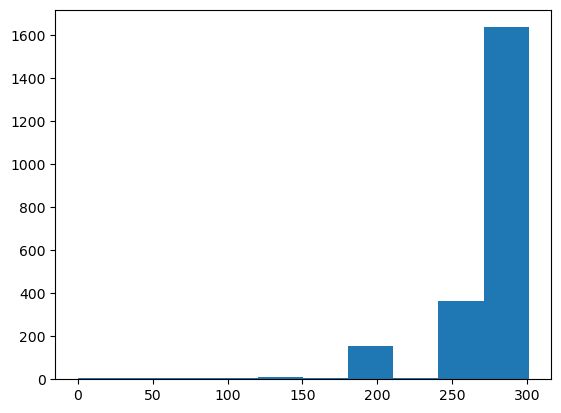

In [74]:
paths_to_videos_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video\*.mp4')

video_lengths_list = []

for path_to_video in tqdm(paths_to_videos_list):
    
    name = os.path.split(path_to_video)[1][:-4]
    path_to_save_numpy = os.path.join(path_to_numpy, name+'.npy')

    frames = read_video_frames_opencv(path_to_video)
    
    frame_num = len(frames)
    video_lengths_list.append(frame_num)

plt.hist(video_lengths_list)

# Превращаем видео в Numpy array, для ускорения обработки

In [ ]:
paths_to_videos_list = glob.glob(r'I:\AVABOS\trash_to_train_on_video\*.mp4')
#paths_to_audios_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_audio\*.wav')

path_to_numpy = r'I:\AVABOS\trash_to_train_on_video_numpy'
os.makedirs(path_to_numpy, exist_ok=True)

video_lengths_list = []

frame_cut_idx = 304 # 16*19

for path_to_video in tqdm(paths_to_videos_list):
    
    name = os.path.split(path_to_video)[1][:-4]
    path_to_save_numpy = os.path.join(path_to_numpy, name + '.npy')

    frames = read_video_frames_opencv(path_to_video)
    
    frame_num = len(frames)
    video_lengths_list.append(frame_num)

    if frame_num == 0:
        continue
    
    if frame_num > frame_cut_idx:
        frames = frames[:frame_cut_idx]
    elif frame_num < frame_cut_idx:
        pad_value = frame_cut_idx - frame_num
        rows = frames.shape[1]
        cols = frames.shape[2]
        channels = frames.shape[3]
        canvas = np.zeros(shape=(frame_cut_idx, rows, cols, channels), dtype=frames.dtype)
        canvas[:frame_num] = frames
        frames = canvas

    frames = frames.transpose(0, 3, 1, 2)

    frames = torch.as_tensor(frames)
    #print(frames.shape)
    tv_frames = tv_tensors.Video(frames)
    #print(tv_frames.shape)
    resizer = v2.Resize(size=(112, 112), antialias=True)
    tv_frames = resizer(tv_frames)
    #print(tv_frames.shape)
    frames = tv_frames.numpy()#.transpose(0, 2, 3, 1)

    np.save(path_to_save_numpy, frames)
    

np.load(path_to_save_numpy).shape, video_lengths_list



In [9]:
paths_to_videos_list = glob.glob(r'I:\AVABOS\trash_to_train_on_video_numpy\*.npy')

train, test = model_selection.train_test_split(paths_to_videos_list, test_size=0.3, random_state=1)
#with open('file_names.txt', 'w') as fd:
indices = [1, 3, 55, 123, 44, 77, 100, 256, 455, 326, 431]

train_names = [os.path.split(p)[-1] for p in train]

with open('train_names.txt', 'w', encoding='utf-8') as fd:
    fd.write('\n'.join(train_names))

with open('train_names.txt', 'r') as fd:
    train_names = fd.read()

train_names = train_names.split('\n')

['DQmiOwaeb5Y(+)_._490.066-500.066_._AGGR.npy',
 'dV6sZNvEFSk(+)_._120.066-130.066_._AGGR.npy',
 '31V2f1CRoX0(+)_._100.066-110.066_._AGGR.npy',
 'ZPK9sLzIjcQ(+)_._10.066-20.066_._NOAGGR.npy',
 'bXEQu52HOKw(+)_._220.066-230.066_._NOAGGR.npy',
 'vU1wiRudB50(+)_._230.066-240.066_._NOAGGR.npy',
 'oFLvI2MmkK0(+)_._30.066-40.066_._NOAGGR.npy',
 '4LUoqxnyxlE(+)_._350.066-360.066_._NOAGGR.npy',
 'hZWn9Nfp6mA(+)_._590.066-600.066_._NOAGGR.npy',
 '4LUoqxnyxlE(+)_._540.066-544.744_._NOAGGR.npy',
 'dg84dhgBmw0(+)_._550.066-560.066_._NOAGGR.npy',
 'qXwYhsoQj34(+)_._210.066-220.066_._AGGR.npy',
 '8zU8uX1XCcE(+)_._330.066-340.066_._AGGR.npy',
 'SgXMh2H0qBU(+)_._170.066-180.066_._NOAGGR.npy',
 'mHOd2VUSCvo(+)_._700.066-710.066_._NOAGGR.npy',
 'EqWiWHAR-j0(+)_._490.066-500.066_._AGGR.npy',
 'fOzMA5D4KUc(+)_._470.066-480.066_._NOAGGR.npy',
 'dg84dhgBmw0(+)_._410.066-420.066_._AGGR.npy',
 'mHOd2VUSCvo(+)_._570.066-580.066_._AGGR.npy',
 'dg84dhgBmw0(+)_._100.066-110.066_._NOAGGR.npy',
 'RUQ4mTzUk4w(+)_._6

In [ ]:
paths_to_videos_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video_numpy\*.npy')

train, test = model_selection.train_test_split(paths_to_videos_list, test_size=0.3, random_state=1)
#with open('file_names.txt', 'w') as fd:
indices = [1, 3, 55, 123, 44, 77, 100, 256, 455, 326, 431]

for idx in indices:
    print(paths_to_videos_list[idx])

In [16]:
npy_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video_numpy\*.npy')
idx = 35
npy_times = []
for i in range(100):
    t0 = time.time()
    frames = np.load(npy_list[idx])
    npy_times.append(time.time()-t0)

print(np.mean(npy_times))

name = os.path.split(npy_list[idx])[1][:-4] + '.mp4'
path_to_video = os.path.join(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video', name)
frames_times = []
for i in range(100):
    t0 = time.time()
    frames = read_video_frames_opencv(path_to_video)
    frames_times.append(time.time()-t0)

print(np.mean(frames_times))

0.02744727611541748
0.3672028565406799


In [ ]:
npy_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video_numpy\*.npy')
for path in tqdm(npy_list):
    frames = np.load(path)

[301, 301]

In [58]:
np.mean(video_lengths_list)

279.82884310618067

(array([  1.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,   2.,   0.,   1.,
          2.,   1.,   0.,   1.,   0.,   2.,   0.,   0.,   1.,   0.,   1.,
          4.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,
         65.,   2.,   1.,   0.,   1.,   0.,  65.,   0., 157.,   0.,  24.,
          0.,  24.,   1.,  64.,  17., 815.]),
 array([  8.  ,  13.86,  19.72,  25.58,  31.44,  37.3 ,  43.16,  49.02,
         54.88,  60.74,  66.6 ,  72.46,  78.32,  84.18,  90.04,  95.9 ,
        101.76, 107.62, 113.48, 119.34, 125.2 , 131.06, 136.92, 142.78,
        148.64, 154.5 , 160.36, 166.22, 172.08, 177.94, 183.8 , 189.66,
        195.52, 201.38, 207.24, 213.1 , 218.96, 224.82, 230.68, 236.54,
        242.4 , 248.26, 254.12, 259.98, 265.84, 271.7 , 277.56, 283.42,
        289.28, 295.14, 301.  ]),
 <BarContainer object of 50 artists>)

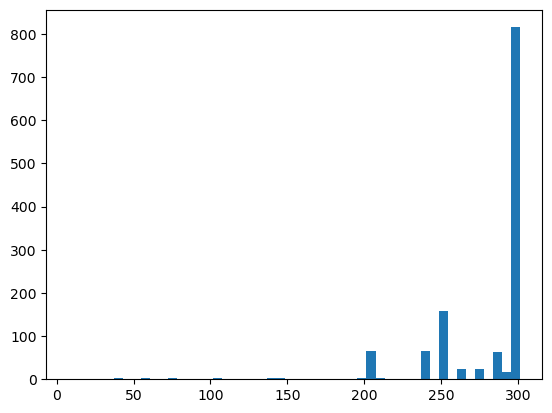

In [72]:
plt.hist(video_lengths_list, bins=50)

In [5]:
paths_to_videos_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_video\*.mp4')
paths_to_audios_list = glob.glob(r'C:\Users\admin\python_programming\DATA\AVABOS\trash_to_train_on_audio\*.wav')
times = []

# test execution time
for i in range(100):
    t0 = time.time()
    #a, b, c, = torchvision.io.read_video(paths_to_videos_list[0])
    frames = read_video_frames_opencv(paths_to_videos_list[0])
    audio = scipy.io.wavfile.read(paths_to_audios_list[0])
    audio = torch.tensor(audio[1])
    times.append(time.time()-t0)

np.mean(times)


0.2548658323287964

In [ ]:
frames = read_video_frames_opencv(paths_to_videos_list[0])
frames

torch.Size([301, 3, 270, 480])
torch.Size([301, 3, 270, 480])


TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


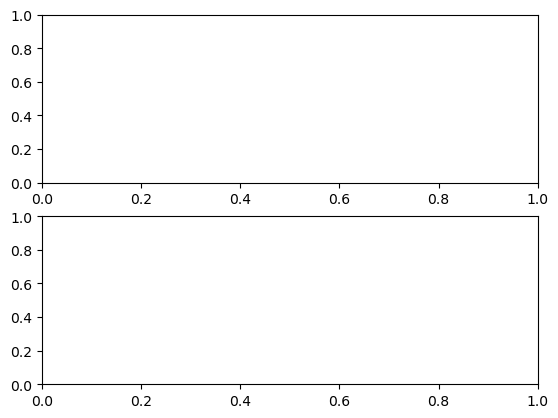

In [50]:
frames = read_video_frames_opencv(paths_to_videos_list[0])
resizer = v2.Resize(size=(224, 224), antialias=True) 
print(frames.shape)

resized_frames = resizer(frames)

print(frames.shape)
fig, axs = plt.subplots(2, 1)

# numpy
#axs[0].imshow(frames[0].transpose(1,2,0))
#axs[1].imshow(resized_frames.transpose(1,2,0))

# pytorch
axs[0].imshow(frames[0].transpose(1,2,0))
axs[1].imshow(resized_frames.transpose(1,2,0))

#plt.imshow(frames[0])

In [51]:
frames[0].transpose(1, 2, 0)

TypeError: transpose() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [48]:
transforms = v2.Compose([
    #v2.ToTensor(),
    #v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomAffine(degrees=20, translate=(0.7, 1.1), scale=(0.6, 1.1), shear=10),
    v2.RandomPesrspective(distortion_scale=0.2),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transformed = transforms(frames)

transformed

array([[[[ 81,  73,  95],
         [ 81,  73,  95],
         [ 81,  73,  95],
         ...,
         [147, 153, 189],
         [147, 153, 189],
         [147, 153, 189]],

        [[ 81,  73,  95],
         [ 81,  73,  95],
         [ 81,  73,  95],
         ...,
         [147, 153, 189],
         [147, 153, 189],
         [147, 153, 189]],

        [[ 81,  73,  95],
         [ 81,  73,  95],
         [ 81,  73,  95],
         ...,
         [147, 153, 189],
         [147, 153, 189],
         [147, 153, 189]],

        ...,

        [[134, 143, 149],
         [181, 190, 196],
         [170, 179, 185],
         ...,
         [ 65,  55,  70],
         [ 73,  60,  76],
         [ 74,  61,  77]],

        [[118, 127, 133],
         [136, 145, 151],
         [133, 142, 148],
         ...,
         [ 65,  55,  70],
         [ 68,  55,  71],
         [ 73,  60,  76]],

        [[105, 114, 120],
         [125, 134, 140],
         [120, 129, 135],
         ...,
         [ 63,  53,  68],
        